<a href="https://colab.research.google.com/github/Jeonghwan-Cheon/Predict-RBP-Binding-RNA-Sequence/blob/master/Predict_RBP_Binding_RNA_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict RBP-BINDING RNA Sequence


> 2020 Fall Semester Bioinformatics  
Project #6  
Jeonghwan Cheon (20190643)  



### Project Goal

In this project, we will predict RBP-binding RNA sequences using a neural network model based on CNN. 

1. Build CNN models for predicting the RBP-binding RNA sequences (ALKBH5 and ELAVL1).
2. Train your model using the training dataset (and optimize your model using validation set).
3. Report the ROC-AUC score of the test dataset using the trained model.
4. Use google colab (or whatever you want)
5. Upload  jupyter notebook (".ipynb" file) or link to your google colab code 



> B. Alipanahi, et al. "Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning", Nature Biotechnology, 33, pages831–838 (2015)



# Setup Environment

In [313]:
! pip install logomaker

In [1]:
# import
import os
import numpy as np
import random

import keras
import tensorflow as tf
###################
# Import keras modules here
###################

In [2]:
# import my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Processing

In [415]:
# read fasta files  
fasta_file_path='gdrive/My Drive/Development Project/Predict RBP-Binding RNA Sequence/data sample/'
print('list of files', os.listdir(fasta_file_path))

# loading dataset
def load_data(rbp_name, property):
  data_fasta = list()
  data_label = list()
  for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and property in x]:
    print('Processing file...', single_file)
    with open(fasta_file_path + single_file) as f:
      for line in f.readlines():
        # get fasta sequence
        if '>' in line:
          continue
        else:
          # make sequence data to uppercase
          data_fasta.append(line.strip().upper()) 
        # get positive negative label
        if 'positives' in single_file:
          data_label.append(1)
        else:
          data_label.append(0)
  return data_fasta, data_label

ELAVL1_train_fasta_raw, ELAVL1_train_label_raw = load_data('ELAVL1', 'train')
ELAVL1_test_fasta_raw, ELAVL1_test_label_raw = load_data('ELAVL1', 'test')
ALKBH5_train_fasta_raw, ALKBH5_train_label_raw = load_data('ALKBH5', 'train')
ALKBH5_test_fasta_raw, ALKBH5_test_label_raw = load_data('ALKBH5', 'test')

list of files ['ALKBH5_Baltz2012.test_negatives.fasta', 'ALKBH5_Baltz2012.test.positives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'CLIPSEQ_ELAVL1.train.positives.fasta']
Processing file... CLIPSEQ_ELAVL1.train.negatives.fasta
Processing file... CLIPSEQ_ELAVL1.train.positives.fasta
Processing file... CLIPSEQ_ELAVL1.test.negatives.fasta
Processing file... CLIPSEQ_ELAVL1.test.positives.fasta
Processing file... ALKBH5_Baltz2012.train.negatives.fasta
Processing file... ALKBH5_Baltz2012.train.positives.fasta
Processing file... ALKBH5_Baltz2012.test_negatives.fasta
Processing file... ALKBH5_Baltz2012.test.positives.fasta


In [462]:
# convert sequence file to one-hot encoding representation
# function: fasta to onehot representation
def convert2onehot(sequence_list):
  map = {
      'A':[1,0,0,0],
      'U':[0,1,0,0],
      'T':[0,1,0,0],
      'G':[0,0,1,0],
      'C':[0,0,0,1]
  }
  
  onehot = []
  for single_sequence in sequence_list:
    single_onehot = []
    for x in single_sequence:
      single_onehot.append(map[x.upper()])
    onehot.append(single_onehot)
    
  return np.asarray(onehot, dtype=np.float32)

# convert sequence file to one-hot encording
ELAVL1_train_val_fasta = convert2onehot(ELAVL1_train_fasta_raw)
ELAVL1_test_fasta = convert2onehot(ELAVL1_test_fasta_raw)
ALKBH5_train_val_fasta = convert2onehot(ALKBH5_train_fasta_raw)
ALKBH5_test_fasta= convert2onehot(ALKBH5_test_fasta_raw)

# convert binary data to categorical data
ELAVL1_train_val_label = keras.utils.to_categorical(ELAVL1_train_label_raw, 2)
ELAVL1_test_label = keras.utils.to_categorical(ELAVL1_test_label_raw, 2)
ALKBH5_train_val_label = keras.utils.to_categorical(ALKBH5_train_label_raw, 2)
ALKBH5_test_label = keras.utils.to_categorical(ALKBH5_test_label_raw, 2)

print('ELAVL1_train_val_fasta: ', ELAVL1_train_val_fasta.shape)
print('ELAVL1_test_fasta: ', ELAVL1_test_fasta.shape)
print('ALKBH5_train_val_fasta: ', ALKBH5_train_val_fasta.shape)
print('ALKBH5_test_fasta: ', ALKBH5_test_fasta.shape)
print('ELAVL1_train_val_label: ', ELAVL1_train_val_label.shape)
print('ELAVL1_test_label: ', ELAVL1_test_label.shape)
print('ALKBH5_train_val_label: ', ALKBH5_train_val_label.shape)
print('ALKBH5_test_label: ', ALKBH5_test_label.shape)

ELAVL1_train_val_fasta:  (16550, 200, 4)
ELAVL1_test_fasta:  (975, 200, 4)
ALKBH5_train_val_fasta:  (2361, 200, 4)
ALKBH5_test_fasta:  (262, 200, 4)
ELAVL1_train_val_label:  (16550, 2)
ELAVL1_test_label:  (975, 2)
ALKBH5_train_val_label:  (2361, 2)
ALKBH5_test_label:  (262, 2)


In [497]:
# split training set into training set and validation set (test:validation = 8:1)
# random shuffling of training data
from sklearn.model_selection import train_test_split

ELAVL1_train_fasta, ELAVL1_val_fasta, ELAVL1_train_label, ELAVL1_val_label = train_test_split(
    ELAVL1_train_val_fasta, ELAVL1_train_val_label, test_size=0.111, shuffle=True, stratify=ELAVL1_train_val_label, random_state=10)
ALKBH5_train_fasta, ALKBH5_val_fasta, ALKBH5_train_label, ALKBH5_val_label = train_test_split(
    ALKBH5_train_val_fasta, ALKBH5_train_val_label, test_size=0.111, shuffle=True, stratify=ALKBH5_train_val_label, random_state=10)

# check the shape of the splited data
print("ELAVL1_train_fasta: ", ELAVL1_train_fasta.shape, "ELAVL1_train_label: ", ELAVL1_train_label.shape)
print("ELAVL1_val_fasta: ", ELAVL1_val_fasta.shape, "ELAVL1_val_label: ", ELAVL1_val_label.shape)
print("ELAVL1_test_fasta: ", ELAVL1_test_fasta.shape, "ELAVL1_test_label: ", ELAVL1_test_label.shape)
print("ALKBH5_train_fasta: ", ALKBH5_train_fasta.shape, "ALKBH5_train_label: ", ALKBH5_train_label.shape)
print("ALKBH5_val_fasta: ", ALKBH5_val_fasta.shape, "ALKBH5_val_label: ", ALKBH5_val_label.shape)
print("ALKBH5_test_fasta: ", ALKBH5_test_fasta.shape, "ALKBH5_test_label: ", ALKBH5_test_label.shape)

print("\n<Final Splited Dataset Ratio>")
print("ELAVL1 Dataset : train(%.02f %%), valid(%.02f %%), test(%.02f %%)" %(float(len(ELAVL1_train_fasta)*100/(len(ELAVL1_train_fasta)+len(ELAVL1_val_fasta)+len(ELAVL1_test_fasta))),
                                                                           float(len(ELAVL1_val_fasta)*100/(len(ELAVL1_train_fasta)+len(ELAVL1_val_fasta)+len(ELAVL1_test_fasta))),
                                                                           float(len(ELAVL1_test_fasta)*100/(len(ELAVL1_train_fasta)+len(ELAVL1_val_fasta)+len(ELAVL1_test_fasta)))))
print("ALKBH5 Dataset: train(%.02f %%), valid(%.02f %%), test(%.02f %%)" %(float(len(ALKBH5_train_fasta)*100/(len(ALKBH5_train_fasta)+len(ALKBH5_val_fasta)+len(ALKBH5_test_fasta))),
                                                                           float(len(ALKBH5_val_fasta)*100/(len(ALKBH5_train_fasta)+len(ALKBH5_val_fasta)+len(ALKBH5_test_fasta))),
                                                                           float(len(ALKBH5_test_fasta)*100/(len(ALKBH5_train_fasta)+len(ALKBH5_val_fasta)+len(ALKBH5_test_fasta)))))

ELAVL1_train_fasta:  (14712, 200, 4) ELAVL1_train_label:  (14712, 2)
ELAVL1_val_fasta:  (1838, 200, 4) ELAVL1_val_label:  (1838, 2)
ELAVL1_test_fasta:  (975, 200, 4) ELAVL1_test_label:  (975, 2)
ALKBH5_train_fasta:  (2098, 200, 4) ALKBH5_train_label:  (2098, 2)
ALKBH5_val_fasta:  (263, 200, 4) ALKBH5_val_label:  (263, 2)
ALKBH5_test_fasta:  (262, 200, 4) ALKBH5_test_label:  (262, 2)

<Final Splited Dataset Ratio>
ELAVL1 Dataset : train(83.95 %), valid(10.49 %), test(5.56 %)
ALKBH5 Dataset: train(79.98 %), valid(10.03 %), test(9.99 %)


In [498]:
from sklearn.utils import shuffle

def add_reversed_sequence(fasta, label):
  # fasta data process
  map = {
    1:[0,1,0,0], # convert A to (U or T)
    2:[1,0,0,0], # convert (U or T) to A
    3:[0,0,0,1], # convert G to C
    4:[0,0,1,0] # convert C to G
  }
  temp_fasta = []
  for single_sequence in fasta:
    single_complementary = []
    for x in single_sequence:
      single_complementary.append(map[np.argmax(x)+1])
    temp_fasta.append(list(reversed(single_complementary))) # reverse order and append

  # label data process
  temp_label = []
  for single_label in label:
    temp_label.append(single_label)
  
  return np.asarray(np.concatenate((fasta, temp_fasta), axis=0), dtype=np.float32), np.asarray(np.concatenate((label, temp_label), axis=0), dtype=np.float32)

print("<Before Adding Reversed and Complementary Sequence>")
print(ELAVL1_train_fasta.shape)
print(ALKBH5_train_fasta.shape)
print(ELAVL1_train_label.shape)
print(ALKBH5_train_label.shape)

# Add Reserved and Complementary Sequence
ELAVL1_train_fasta, ELAVL1_train_label = add_reversed_sequence(ELAVL1_train_fasta, ELAVL1_train_label)
ALKBH5_train_fasta, ALKBH5_train_label = add_reversed_sequence(ALKBH5_train_fasta, ALKBH5_train_label)

# Shuffle Dataset
ELAVL1_train_fasta, ELAVL1_train_label = shuffle(ELAVL1_train_fasta, ELAVL1_train_label)
ALKBH5_train_fasta, ALKBH5_train_label = shuffle(ALKBH5_train_fasta, ALKBH5_train_label)
ELAVL1_val_fasta, ELAVL1_val_label = shuffle(ELAVL1_val_fasta, ELAVL1_val_label)
ALKBH5_val_fasta, ALKBH5_val_label = shuffle(ALKBH5_val_fasta, ALKBH5_val_label)
ELAVL1_test_fasta, ELAVL1_test_label = shuffle(ELAVL1_test_fasta, ELAVL1_test_label)
ALKBH5_test_fasta, ALKBH5_test_label = shuffle(ALKBH5_test_fasta, ALKBH5_test_label)


print("<After Adding Reversed and Complementary Sequence>")
print(ELAVL1_train_fasta.shape)
print(ALKBH5_train_fasta.shape)
print(ELAVL1_train_label.shape)
print(ALKBH5_train_label.shape)

<Before Adding Reversed and Complementary Sequence>
(14712, 200, 4)
(2098, 200, 4)
(14712, 2)
(2098, 2)
<After Adding Reversed and Complementary Sequence>
(29424, 200, 4)
(4196, 200, 4)
(29424, 2)
(4196, 2)


In [499]:
# reshape dataset

ELAVL1_train_fasta = ELAVL1_train_fasta.reshape((-1, 200, 4))
ELAVL1_val_fasta = ELAVL1_val_fasta.reshape((-1, 200, 4))
ELAVL1_test_fasta = ELAVL1_test_fasta.reshape((-1, 200, 4))
ALKBH5_train_fasta = ALKBH5_train_fasta.reshape((-1, 200, 4))
ALKBH5_val_fasta = ALKBH5_val_fasta.reshape((-1, 200, 4))
ALKBH5_test_fasta = ALKBH5_test_fasta.reshape((-1, 200, 4))

print("ELAVL1_train_fasta: ", ELAVL1_train_fasta.shape, "ELAVL1_train_label: ", ELAVL1_train_label.shape)
print("ELAVL1_val_fasta: ", ELAVL1_val_fasta.shape, "ELAVL1_val_label: ", ELAVL1_val_label.shape)
print("ELAVL1_test_fasta: ", ELAVL1_test_fasta.shape, "ELAVL1_test_label: ", ELAVL1_test_label.shape)
print("ALKBH5_train_fasta: ", ALKBH5_train_fasta.shape, "ALKBH5_train_label: ", ALKBH5_train_label.shape)
print("ALKBH5_val_fasta: ", ALKBH5_val_fasta.shape, "ALKBH5_val_label: ", ALKBH5_val_label.shape)
print("ALKBH5_test_fasta: ", ALKBH5_test_fasta.shape, "ALKBH5_test_label: ", ALKBH5_test_label.shape)

ELAVL1_train_fasta:  (29424, 200, 4) ELAVL1_train_label:  (29424, 2)
ELAVL1_val_fasta:  (1838, 200, 4) ELAVL1_val_label:  (1838, 2)
ELAVL1_test_fasta:  (975, 200, 4) ELAVL1_test_label:  (975, 2)
ALKBH5_train_fasta:  (4196, 200, 4) ALKBH5_train_label:  (4196, 2)
ALKBH5_val_fasta:  (263, 200, 4) ALKBH5_val_label:  (263, 2)
ALKBH5_test_fasta:  (262, 200, 4) ALKBH5_test_label:  (262, 2)


# Building Convolutional Neural Network (CNN)

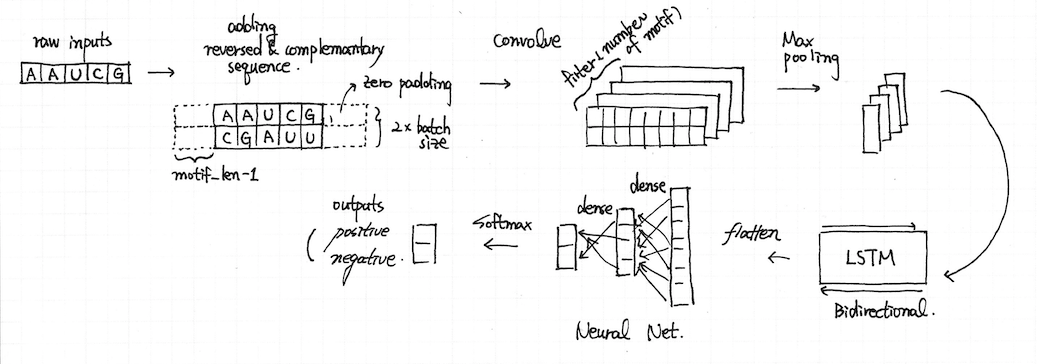

In [500]:
# model building
def build_model():
  motif_len = 15
  motif_num = 4
  # add layers to build a model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters = motif_num, kernel_size = motif_len, activation='relu',input_shape=(200, 4), padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=10, strides=10))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(motif_num, return_sequences=True)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  model.add(tf.keras.layers.Dense(units=2, activation='relu'))
  model.add(tf.keras.layers.Softmax(name="softmax"))
  model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  return model

# make a prediction model for ELAVL1
model_ELAVL1 = build_model()
model_ELAVL1.summary() # print summary of ELAVL1 model

# make a prediction model for ALKBH5
model_ALKBH5 = build_model()
model_ALKBH5.summary() # print summary of ALKBH5 model

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 200, 4)            244       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 20, 4)             0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 20, 8)             288       
_________________________________________________________________
flatten_48 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 20)                3220      
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 42        
_________________________________________________________________
softmax (Softmax)            (None, 2)               

In [501]:
# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_ELAVL1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc_ELAVL1 = ModelCheckpoint('best_model_ELAVL1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es_ALKBH5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc_ALKBH5 = ModelCheckpoint('best_model_ALKBH5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [503]:
# model training
epochs = 200

hist_ELAVL1 = model_ELAVL1.fit(
    ELAVL1_train_fasta, ELAVL1_train_label,
    validation_data=(ELAVL1_val_fasta, ELAVL1_val_label),
    batch_size=32, epochs=epochs, verbose=1, callbacks=[es_ELAVL1, mc_ELAVL1])

Epoch 1/200
918/920 [============================>.] - ETA: 0s - loss: 0.5868 - accuracy: 0.6909
Epoch 00001: val_accuracy improved from -inf to 0.76877, saving model to best_model_ELAVL1.h5
920/920 [==============================] - 6s 7ms/step - loss: 0.5866 - accuracy: 0.6911 - val_loss: 0.4860 - val_accuracy: 0.7688
Epoch 2/200
912/920 [============================>.] - ETA: 0s - loss: 0.4660 - accuracy: 0.7769
Epoch 00002: val_accuracy improved from 0.76877 to 0.79815, saving model to best_model_ELAVL1.h5
920/920 [==============================] - 6s 6ms/step - loss: 0.4653 - accuracy: 0.7774 - val_loss: 0.4467 - val_accuracy: 0.7982
Epoch 3/200
914/920 [============================>.] - ETA: 0s - loss: 0.4179 - accuracy: 0.8082
Epoch 00003: val_accuracy improved from 0.79815 to 0.83243, saving model to best_model_ELAVL1.h5
920/920 [==============================] - 6s 6ms/step - loss: 0.4175 - accuracy: 0.8083 - val_loss: 0.3848 - val_accuracy: 0.8324
Epoch 4/200
918/920 [=======

In [502]:
hist_ALKBH5 = model_ALKBH5.fit(
    ALKBH5_train_fasta, ALKBH5_train_label,
    validation_data=(ALKBH5_val_fasta, ALKBH5_val_label),
    batch_size=64, epochs=epochs, verbose=1, callbacks=[es_ALKBH5, mc_ALKBH5])

Epoch 1/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6945 - accuracy: 0.4995
Epoch 00001: val_accuracy improved from -inf to 0.54753, saving model to best_model_ALKBH5.h5
66/66 [==============================] - 1s 15ms/step - loss: 0.6944 - accuracy: 0.5007 - val_loss: 0.6895 - val_accuracy: 0.5475
Epoch 2/200
63/66 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5250
Epoch 00002: val_accuracy improved from 0.54753 to 0.56654, saving model to best_model_ALKBH5.h5
66/66 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5234 - val_loss: 0.6895 - val_accuracy: 0.5665
Epoch 3/200
65/66 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5240
Epoch 00003: val_accuracy did not improve from 0.56654
66/66 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5245 - val_loss: 0.6893 - val_accuracy: 0.5551
Epoch 4/200
62/66 [===========================>..] - ETA: 0s - loss: 0.6921 - acc

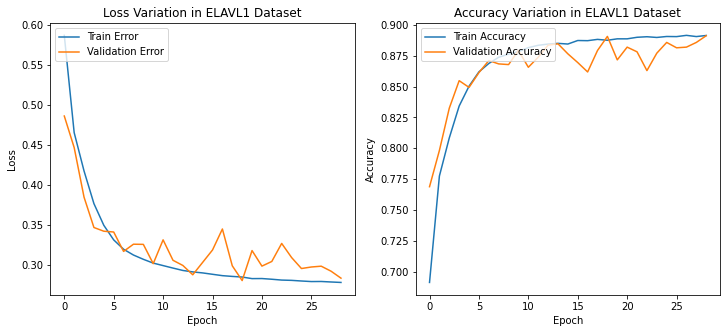

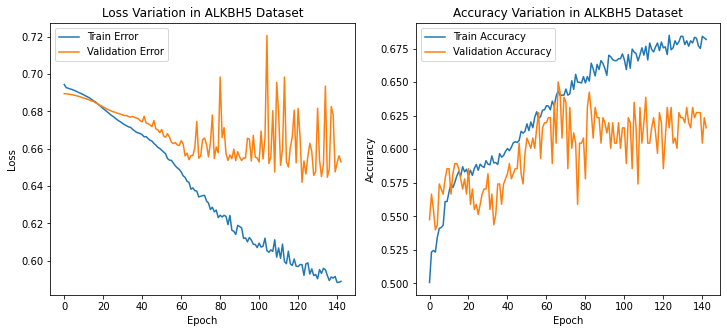

In [504]:
# plot the accuracy and loss value of each model.
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history, name):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Loss Variation in "+name+" Dataset")
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Validation Error')
  plt.legend(loc='upper left')

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Variation in "+name+" Dataset")
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Validation Accuracy')
  plt.legend(loc='upper left')

plot_history(hist_ELAVL1, "ELAVL1")
plot_history(hist_ALKBH5, "ALKBH5")

# Evaluating Model

In [505]:
# load the best model
from keras.models import load_model
saved_model_ELAVL1 = load_model('best_model_ELAVL1.h5')
saved_model_ELAVL1.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

saved_model_ALKBH5 = load_model('best_model_ALKBH5.h5')
saved_model_ALKBH5.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [506]:
train_loss_ELAVL1, train_acc_ELAVL1 = saved_model_ELAVL1.evaluate(ELAVL1_train_fasta, ELAVL1_train_label, verbose=0)
valid_loss_ELAVL1, valid_acc_ELAVL1 = saved_model_ELAVL1.evaluate(ELAVL1_val_fasta, ELAVL1_val_label, verbose=0)
test_loss_ELAVL1, test_acc_ELAVL1 = saved_model_ELAVL1.evaluate(ELAVL1_test_fasta, ELAVL1_test_label, verbose=0)

train_loss_ALKBH5, train_acc_ALKBH5 = saved_model_ALKBH5.evaluate(ALKBH5_train_fasta, ALKBH5_train_label, verbose=0)
valid_loss_ALKBH5, valid_acc_ALKBH5 = saved_model_ALKBH5.evaluate(ALKBH5_val_fasta, ALKBH5_val_label, verbose=0)
test_loss_ALKBH5, test_acc_ALKBH5 = saved_model_ALKBH5.evaluate(ALKBH5_test_fasta, ALKBH5_test_label, verbose=0)

print('<ELAVL1 Dataset>')
print(f'Accuracy of Train: {train_acc_ELAVL1:.3f}, Validation: {valid_acc_ELAVL1:.3f}, Test: {test_acc_ELAVL1:.3f}')
print(f'Loss of Train: {train_loss_ELAVL1:.3f}, Validation {valid_loss_ELAVL1:.3f}, Test: {test_loss_ELAVL1:.3f}')

print('<ALKBH5 Dataset>')
print(f'Accuracy of Train: {train_acc_ALKBH5:.3f}, Validation: {valid_acc_ALKBH5:.3f}, Test: {test_acc_ALKBH5:.3f}')
print(f'Loss of Train: {train_loss_ALKBH5:.3f}, Validation {valid_loss_ALKBH5:.3f}, Test: {test_loss_ALKBH5:.3f}')

<ELAVL1 Dataset>
Accuracy of Train: 0.891, Validation: 0.891, Test: 0.877
Loss of Train: 0.278, Validation 0.284, Test: 0.304
<ALKBH5 Dataset>
Accuracy of Train: 0.647, Validation: 0.650, Test: 0.630
Loss of Train: 0.635, Validation 0.656, Test: 0.640


In [507]:
def toScore(X_test, Y_test, model):
  Y_pred = model.predict(X_test)
  temp = []
  for i in range(len(Y_test)):
    temp.append(Y_pred[i][1])
  return temp

label_true_ELAVL1 = [np.argmax(y) for y in ELAVL1_test_label] # convert one-hot encoding to label
label_pred_ELAVL1 = [np.argmax(y) for y in saved_model_ELAVL1.predict(ELAVL1_test_fasta)] # convert one-hot encoding to prediction label
pos_score_ELAVL1 = [y[1] for y in saved_model_ELAVL1.predict(ELAVL1_test_fasta)] # convert one-hot encording to score for positive class

label_true_ALKBH5 = [np.argmax(y) for y in ALKBH5_test_label] # convert one-hot encoding to label
label_pred_ALKBH5 = [np.argmax(y) for y in saved_model_ALKBH5.predict(ALKBH5_test_fasta)] # convert one-hot encoding to prediction label
pos_score_ALKBH5 = [y[1] for y in saved_model_ALKBH5.predict(ALKBH5_test_fasta)] # convert one-hot encording to score for positive class

In [508]:
# evaluate the prediction model using test dataset.
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns   

# Run classifier with cross-validation and plot ROC curves
def evaluate_model(y_true, y_pred, y_score):
  target_names = ['activation', 'inactivation']
  print("<Classification Report>")
  print(classification_report(y_true, y_pred, target_names=target_names))

  print("<ROC curve and AUC Score>")
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

  cm = confusion_matrix(y_true, y_pred)
  print("<Confusion Matrix>")
  print("TN: ",cm[0][0],  "FP: ", cm[0][1] )
  print("FN: ", cm[1][0], "TP: ", cm[1][1])

  cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
  ax= plt.subplot()
  sns.heatmap(cm_normalized, annot=True, ax = ax, cmap='Blues'); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted Classes');
  ax.set_ylabel('True Classes'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['Negative', 'Positive']);
  ax.yaxis.set_ticklabels(['Negative', 'Positive']);

  return

<Classification Report>
              precision    recall  f1-score   support

  activation       0.86      0.91      0.88       496
inactivation       0.90      0.85      0.87       479

    accuracy                           0.88       975
   macro avg       0.88      0.88      0.88       975
weighted avg       0.88      0.88      0.88       975

<ROC curve and AUC Score>


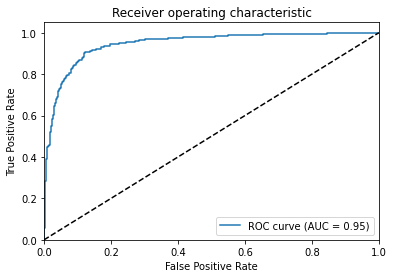

<Confusion Matrix>
TN:  450 FP:  46
FN:  74 TP:  405


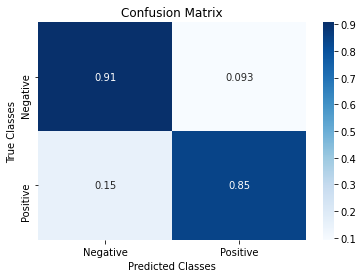

In [509]:
# AUC of ELAVL1 dataset
evaluate_model(label_true_ELAVL1 , label_pred_ELAVL1 , pos_score_ELAVL1)

<Classification Report>
              precision    recall  f1-score   support

  activation       0.60      0.77      0.68       131
inactivation       0.68      0.49      0.57       131

    accuracy                           0.63       262
   macro avg       0.64      0.63      0.62       262
weighted avg       0.64      0.63      0.62       262

<ROC curve and AUC Score>


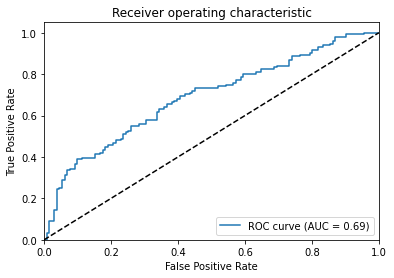

<Confusion Matrix>
TN:  101 FP:  30
FN:  67 TP:  64


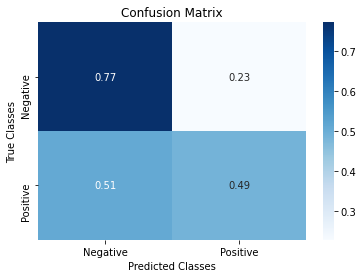

In [510]:
# AUC of ALKBH5 dataset
evaluate_model(label_true_ALKBH5 , label_pred_ALKBH5, pos_score_ALKBH5)

# Visualizing RNA Motif

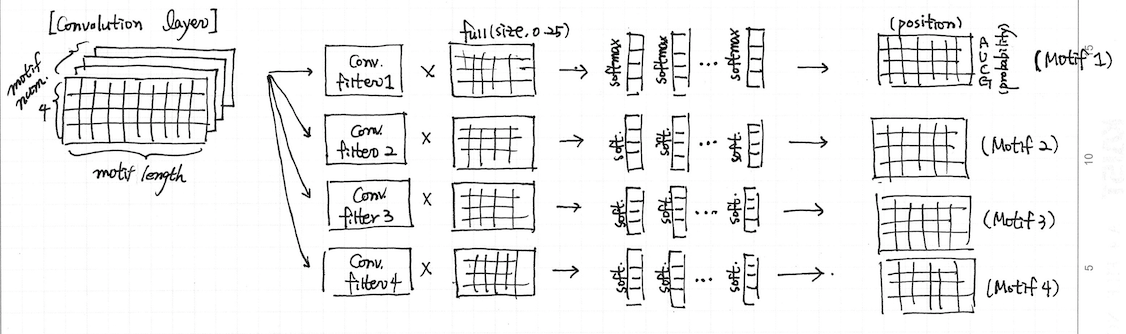

In [511]:
from scipy.special import softmax

def normalize_softmax(data):
  temp = []
  for i in range(len(data)):
    temp.append(list(softmax(data[i])))
  return np.array(temp)

# get CNN filter and convert to motif feature in ELAVL1 model

for layer in saved_model_ELAVL1.layers:
  if 'conv' in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    motif_filter_ELAVL1 = filters.transpose()

ELAVL1_motif_raw_1 = np.multiply(np.full((4, 15), 0.25), motif_filter_ELAVL1[0])
ELAVL1_motif_raw_2 = np.multiply(np.full((4, 15), 0.25), motif_filter_ELAVL1[1])
ELAVL1_motif_raw_3 = np.multiply(np.full((4, 15), 0.25), motif_filter_ELAVL1[2])
ELAVL1_motif_raw_4 = np.multiply(np.full((4, 15), 0.25), motif_filter_ELAVL1[3])

ELAVL1_motif_1  = normalize_softmax(ELAVL1_motif_raw_1 .transpose() * 100)
ELAVL1_motif_2  = normalize_softmax(ELAVL1_motif_raw_2 .transpose() * 100)
ELAVL1_motif_3  = normalize_softmax(ELAVL1_motif_raw_3 .transpose() * 100)
ELAVL1_motif_4  = normalize_softmax(ELAVL1_motif_raw_4 .transpose() * 100)

conv1d_37 (15, 4, 4)


In [512]:
# get CNN filter and convert to motif feature in ALKBH5 model

for layer in saved_model_ALKBH5.layers:
  if 'conv' in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)
    motif_filter_ALKBH5 = filters.transpose()

ALKBH5_motif_raw_1 = np.multiply(np.full((4, 15), 0.25), motif_filter_ALKBH5[0])
ALKBH5_motif_raw_2 = np.multiply(np.full((4, 15), 0.25), motif_filter_ALKBH5[1])
ALKBH5_motif_raw_3 = np.multiply(np.full((4, 15), 0.25), motif_filter_ALKBH5[2])
ALKBH5_motif_raw_4 = np.multiply(np.full((4, 15), 0.25), motif_filter_ALKBH5[3])

ALKBH5_motif_1  = normalize_softmax(ALKBH5_motif_raw_1 .transpose() * 100)
ALKBH5_motif_2  = normalize_softmax(ALKBH5_motif_raw_2 .transpose() * 100)
ALKBH5_motif_3  = normalize_softmax(ALKBH5_motif_raw_3 .transpose() * 100)
ALKBH5_motif_4  = normalize_softmax(ALKBH5_motif_raw_4 .transpose() * 100)

conv1d_38 (15, 4, 4)


In [513]:
import logomaker
import pandas as pd

def logo(data):
  # load position weight matrix
  df = pd.DataFrame(data)
  df = df.rename(columns={0: "A", 1: "U", 2 : "C", 3 : "G"})

  # create Logo object
  crp_logo = logomaker.Logo(df,
                            shade_below=.5,
                            fade_below=.5,
                            font_name='Arial Rounded MT Bold')

  # style using Logo methods
  crp_logo.style_spines(visible=False)
  crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
  crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

  # style using Axes methods
  crp_logo.ax.set_xlabel("Position", labelpad=-1)
  crp_logo.ax.set_ylabel("Probability", labelpad=-1)
  crp_logo.ax.xaxis.set_ticks_position('none')
  crp_logo.ax.xaxis.set_tick_params(pad=-1)

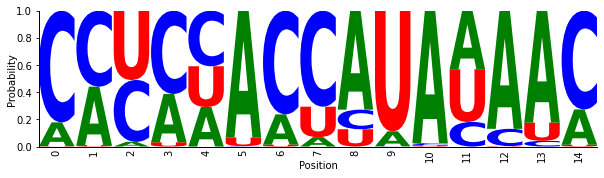

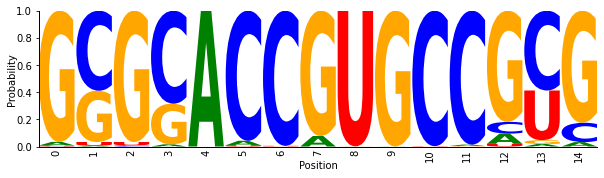

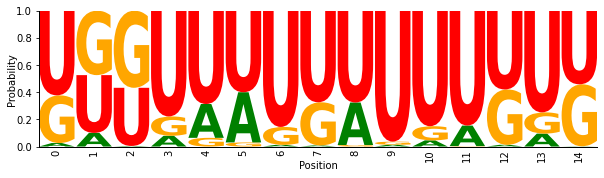

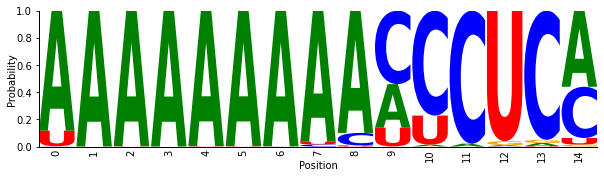

In [514]:
logo(ELAVL1_motif_1)
logo(ELAVL1_motif_2)
logo(ELAVL1_motif_3)
logo(ELAVL1_motif_4)

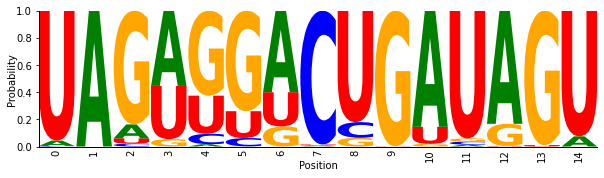

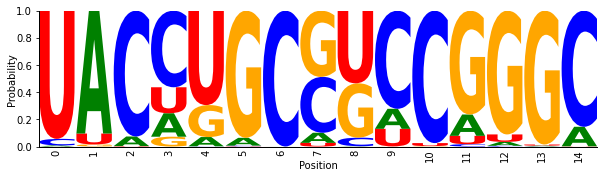

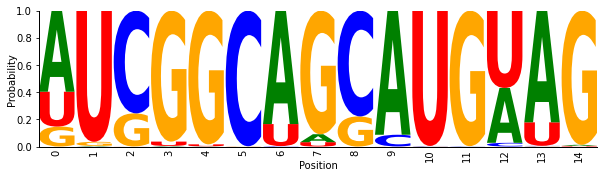

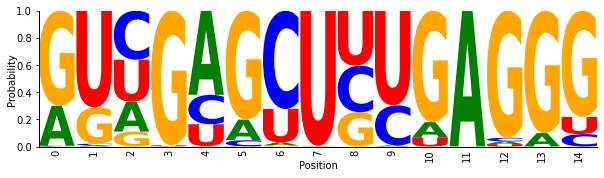

In [515]:
logo(ALKBH5_motif_1)
logo(ALKBH5_motif_2)
logo(ALKBH5_motif_3)
logo(ALKBH5_motif_4)